Internet use and religion in Europe, part six
-----------------------------------------

This notebook presents explorations of the association between Internet use and religion in Europe, using data from the European Social Survey (http://www.europeansocialsurvey.org).

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import string
import random
import cPickle as pickle

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import thinkstats2
import thinkplot
import matplotlib.pyplot as plt

import ess

# colors by colorbrewer2.org
BLUE1 = '#a6cee3'
BLUE2 = '#1f78b4'
GREEN1 = '#b2df8a'
GREEN2 = '#33a02c'
PINK = '#fb9a99'
RED = '#e31a1c'
ORANGE1 = '#fdbf6f'
ORANGE2 = '#ff7f00'
PURPLE1 = '#cab2d6'
PURPLE2 = '#6a3d9a'
YELLOW = '#ffff99'
BROWN = '#b15928'

%matplotlib inline

Open the store containing resampled DataFrames.

In [2]:
store = pd.HDFStore('ess.resamples.h5')

In [3]:
country_map = ess.make_countries(store)

Austria
Belgium
Bulgaria
Switzerland
Cyprus
Czech Rep
Germany
Denmark
Estonia
Spain
Finland
France
UK
Greece
Croatia
Hungary
Ireland
Israel
Iceland
Italy
Lithuania
Luxembourg
Latvia
Netherlands
Norway
Poland
Portugal
Romania
Russia
Sweden
Slovenia
Slovakia
Turkey
Ukraine


In [4]:
FORMULA1 = ('treatment ~ inwyr07_f + yrbrn60_f + yrbrn60_f2 + '
            'edurank_f + hincrank_f +'
            'tvtot_f + rdtot_f + nwsptot_f')

def compute_delta(group, country):
    group['yrbrn60_f2'] = group.yrbrn60_f ** 2
    group['propensity'] = np.nan
    group['treatment'] = np.nan
        
    # quantize netuse to get treatment variable
    # choose threshold close to the median
    netuse = group.netuse_f
    thresh = netuse.median()
    if thresh < 1:
        thresh = 1
    group.treatment = (netuse >= thresh).astype(int)

    # compute propensities
    model = smf.logit(FORMULA1, data=group)    
    results = model.fit(disp=False)
    group.propensity = results.predict(group)
    
    # divide into treatment and control groups
    treatment = group[group.treatment == 1]
    control = group[group.treatment == 0]
    
    # sort the propensities of the controls (for fast lookup)
    series = control.propensity.sort_values()

    # look up the propensities of the treatment group
    # to find (approx) closest matches in the control group
    indices = series.searchsorted(treatment.propensity)
    indices[indices < 0] = 0
    indices[indices >= len(control)] = len(control)-1
    
    # use the indices to select the matches
    control_indices = series.index[indices]
    matches = control.loc[control_indices]

    # find distances and differences
    distances = (treatment.propensity.values - 
                 matches.propensity.values)
    differences = (treatment.rlgdgr_f.values - 
                   matches.rlgdgr_f.values)
    
    # select differences with small distances
    caliper = differences[abs(distances) < 0.001]

    # return the mean difference
    delta = np.mean(caliper)
    return delta

In [5]:
def process_frame(df, country_map):
    grouped = df.groupby('cntry')
    for code, group in grouped:
        country = country_map[code]

        # compute mean difference between matched pairs
        delta = compute_delta(group, country)
        d = dict(delta=delta)
        country.add_params(d)

In [6]:
def process_all_frames(store, country_map, num=201):
    """Loops through the store and processes frames.
    
    store: store
    country_map: map from code to Country
    num: how many resamplings to process
    reg_func: function used to compute regression
    formula: string Patsy formula
    model_num: which model we're running
    """
    for i, key in enumerate(store.keys()):
        if i >= num:
            break
        print(i, key)
        df = store.get(key)
        process_frame(df, country_map)

In [7]:
process_all_frames(store, country_map, num=101)

/home/downey/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/downey/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/downey/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

0 /AAVZWa
1 /ADbUvD
2 /AJEDdF
3 /AOacJP
4 /AsSyrK
5 /BIXejR
6 /Blwttj
7 /BytXnJ
8 /CuiQgF
9 /CxkVBv
10 /DOKcxz
11 /DSSzPM
12 /DdpHTg
13 /EBHNWn
14 /EHuhuk
15 /EIaigX
16 /EOOBpB
17 /EdeAYH
18 /EiftYh
19 /EoHBcy
20 /Evkitq
21 /FJboqX
22 /FWawby
23 /GIKXkG
24 /GPBBMj
25 /GYhuaT
26 /GdTLTY
27 /GeUlsB
28 /GeolrR
29 /GkMwBV
30 /GownbC
31 /GrCTmE
32 /HGSBFA
33 /HemGKU
34 /HujYDN
35 /IKLjEu
36 /IORbkE
37 /IXYMov
38 /InEXbB
39 /JKBolS
40 /JVSJPq
41 /JofMZK
42 /JomohW
43 /JznRlw
44 /KEthFz
45 /KFwczR
46 /KUVnJc
47 /KnKXTR
48 /KuGUhG
49 /KudtCP
50 /LaUmLC
51 /LissvE
52 /LmraEV
53 /MCmopN
54 /MIdmWa
55 /MgSdJx
56 /NJjQrX
57 /NfzPAX
58 /OJZEtt
59 /Oaksmf
60 /OdhAjf
61 /PJETsk
62 /PXxSpS
63 /PiWfGA
64 /PptHII
65 /PvfGpy
66 /QTTYTa
67 /QbhbQt
68 /QoHLXF
69 /QskeUe
70 /QtkeEX
71 /RHVBHl
72 /RRpxwc
73 /RYtpJo
74 /RuCVox
75 /RwJMYt
76 /SHnJcB
77 /ScbnLb
78 /TOcaLi
79 /TRVSRU
80 /TaHTXL
81 /UKzbGY
82 /UVvNeb
83 /UfXGIO
84 /VHIVpS
85 /VcRwRL
86 /VgqgVe
87 /VlUfcv
88 /VzZAXk
89 /WczOWP
90 /WkLtrX
91 /WkfCQ

/home/downey/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
store.close()

In [9]:
with open('ess6.pkl', 'wb') as fp:
    pickle.dump(country_map, fp)

In [17]:
with open('ess6.pkl', 'rb') as fp:
    country_map = pickle.load(fp)

In [18]:
len(country_map['DE'].param_seq)

101

In [25]:
plot_counter = 1

def save_plot(flag=False):
    """Saves plots in png format.
    
    flag: boolean, whether to save or not
    """
    global plot_counter
    if flag:
        root = 'ess6.%2.2d' % plot_counter
        thinkplot.Save(root=root, formats=['png'])
        plot_counter += 1

Make a plot showing confidence interval of effect size for the given parameters

In [26]:
xlabel1 = 'Difference in religiosity (10 point scale)'

In [29]:
xlim = [-2.5, 1.0]

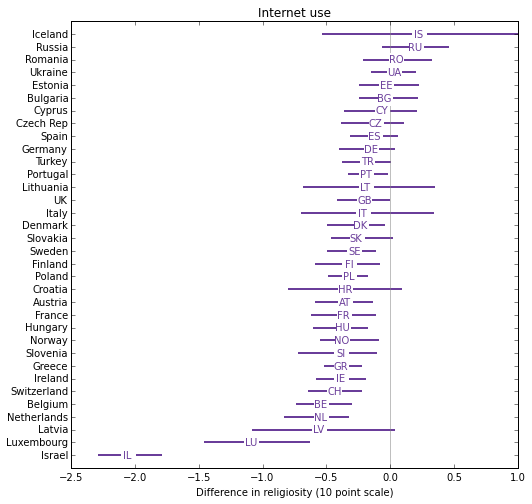

In [30]:
reload(ess)
t = ess.extract_vars(country_map, 'delta', None)
ess.plot_cis(t, PURPLE2)
thinkplot.Config(title='Internet use',
                 xlabel=xlabel1, xlim=xlim)
save_plot()

Why bigger CIs?  

1. Discarding some data, so smaller sample size.
2. Does matching cut the sample size by half?
3. Biggest one, probably: reducing netuse_f to a binary variable.  

-0.313520305287 -0.282269798379


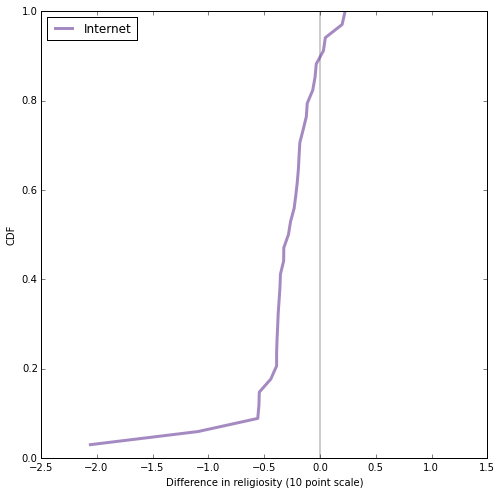

In [19]:
reload(ess)
cdfnames = ['delta']
ess.plot_cdfs(country_map, ess.extract_vars, cdfnames=cdfnames)
thinkplot.Config(xlabel=xlabel1,
                 xlim=xlim,
                 ylabel='CDF',
                 loc='upper left')
save_plot()

In [20]:
reload(ess)
varnames = ['delta']

ts = ess.make_table(country_map, varnames, ess.extract_vars)
ess.print_table(ts)

varname  	neg*  	neg  	pos  	pos*
---------  	----  	---  	---  	----
delta  	18  	12  	4  	0  	34
